In [2]:
import math
import random
import pickle
import itertools

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

from sklearn.utils import shuffle

from scipy.signal import resample

import matplotlib.pyplot as pl

np.random.seed(42)

import pickle
from sklearn.preprocessing import OneHotEncoder

from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation# , Dropout
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [4]:
import os
print(os.listdir(r'C:\Users\Usuario\Desktop\CNN_Ac'
))

['.dist', 'arrhythmia-Model.ipynb', 'arrhythmia-on-ecg-classification-using-cnn.ipynb', 'best_model.h5', 'mitbih_test.csv', 'mitbih_train.csv', 'ptbdb_abnormal.csv']


In [5]:
df = pd.read_csv(r'C:\Users\Usuario\Desktop\CNN_Ac\mitbih_train.csv', header=None)
df2 = pd.read_csv(r'C:\Users\Usuario\Desktop\CNN_Ac\mitbih_test.csv', header=None)
df = pd.concat([df, df2], axis=0)

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB


In [8]:
df[187].value_counts()

187
0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: count, dtype: int64

In [9]:
M = df.values
X = M[:, :-1]
y = M[:, -1].astype(int)

In [10]:
del df
del df2
del M

In [11]:
C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()

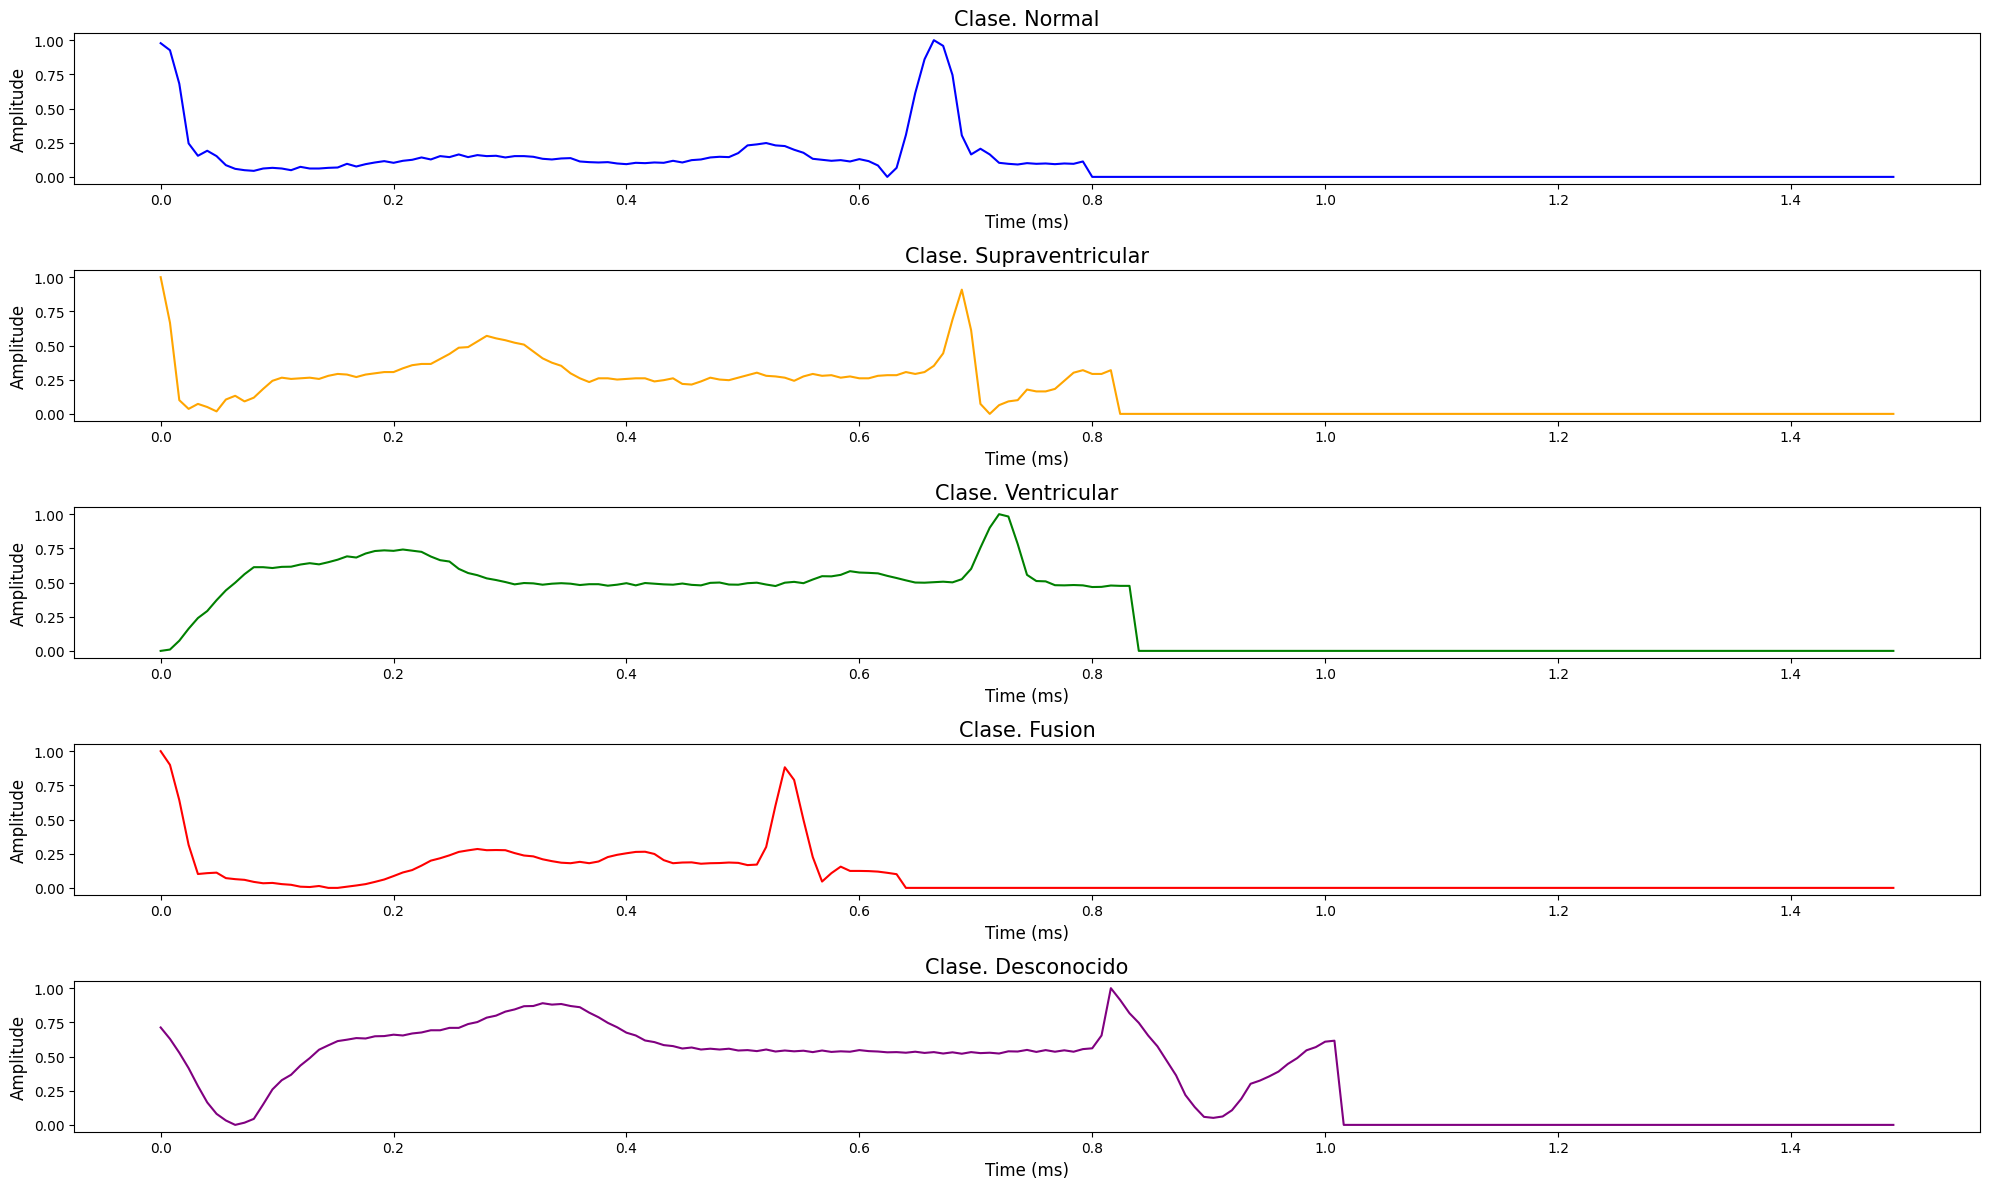

In [12]:
x = np.arange(0, 187) * 8 / 1000

plt.figure(figsize=(20, 12))

# Grafica de Clase. Normal
plt.subplot(5, 1, 1)
plt.plot(x, X[C0, :][0],color='blue')
plt.title("Clase. Normal", fontsize=15)
plt.ylabel("Amplitude", fontsize=12)
plt.xlabel("Time (ms)", fontsize=12)

# Grafica de Clase. Supraventricular
plt.subplot(5, 1, 2)
plt.plot(x, X[C1, :][0],color='orange')
plt.title("Clase. Supraventricular", fontsize=15)
plt.ylabel("Amplitude", fontsize=12)
plt.xlabel("Time (ms)", fontsize=12)

# Grafica de Clase. Ventricular
plt.subplot(5, 1, 3)
plt.plot(x, X[C2, :][0], color = 'green')
plt.title("Clase. Ventricular", fontsize=15)
plt.ylabel("Amplitude", fontsize=12)
plt.xlabel("Time (ms)", fontsize=12)

# Grafica de Clase. Fusion
plt.subplot(5, 1, 4)
plt.plot(x, X[C3, :][0], color= "red")
plt.title("Clase. Fusion", fontsize=15)
plt.ylabel("Amplitude", fontsize=12)
plt.xlabel("Time (ms)", fontsize=12)

# Grafica de Clase. Desconocido
plt.subplot(5, 1, 5)
plt.plot(x, X[C4, :][0], color= "purple")
plt.title("Clase. Desconocido", fontsize=15)
plt.ylabel("Amplitude", fontsize=12)
plt.xlabel("Time (ms)", fontsize=12)

plt.tight_layout()
plt.show()

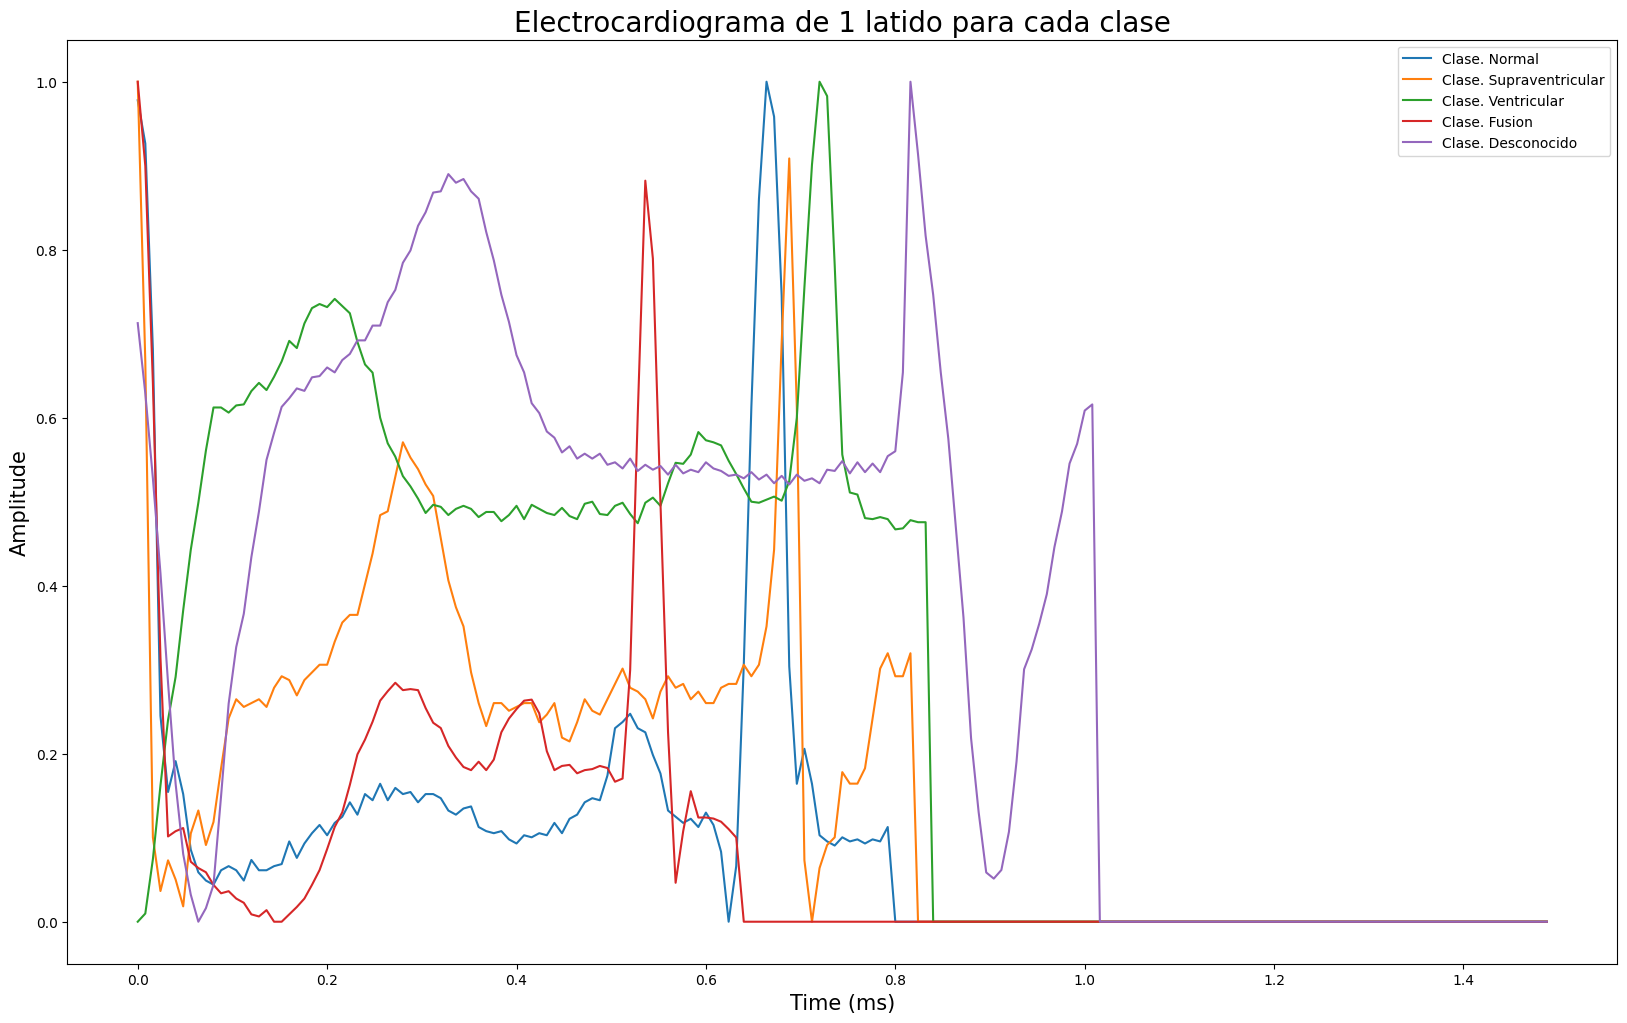

In [13]:
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,12))
plt.plot(x, X[C0, :][0], label="Clase. Normal")
plt.plot(x, X[C1, :][0], label="Clase. Supraventricular")
plt.plot(x, X[C2, :][0], label="Clase. Ventricular")
plt.plot(x, X[C3, :][0], label="Clase. Fusion")
plt.plot(x, X[C4, :][0], label="Clase. Desconocido")
plt.legend()
plt.title("Electrocardiograma de 1 latido para cada clase", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

# Entrenamiento

Para un buen entrenamiento debemos aumentar todos las clases al mismo nivel , en este caso las Clases supraventricular y  Fusion se ven afectadas ya que tenian el valor mas  debil


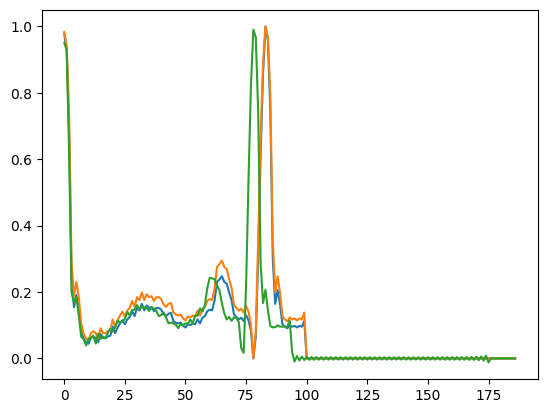

In [14]:
def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def augment(x):
    result = np.zeros(shape= (4, 187))
    for i in range(3):
        if random.random() < 0.33:
            new_y = stretch(x)
        elif random.random() < 0.66:
            new_y = amplify(x)
        else:
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
    return result

plt.plot(X[0, :])
plt.plot(amplify(X[0, :]))
plt.plot(stretch(X[0, :]))
plt.show()

In [15]:
result = np.apply_along_axis(augment, axis=1, arr=X[C3]).reshape(-1, 187)
classe = np.ones(shape=(result.shape[0],), dtype=int)*3
X = np.vstack([X, result])
y = np.hstack([y, classe])

In [16]:
subC0 = np.random.choice(C0, 800)
subC1 = np.random.choice(C1, 800)
subC2 = np.random.choice(C2, 800)
subC3 = np.random.choice(C3, 800)
subC4 = np.random.choice(C4, 800)

In [17]:
X_test = np.vstack([X[subC0], X[subC1], X[subC2], X[subC3], X[subC4]])
y_test = np.hstack([y[subC0], y[subC1], y[subC2], y[subC3], y[subC4]])

X_train = np.delete(X, [subC0, subC1, subC2, subC3, subC4], axis=0)
y_train = np.delete(y, [subC0, subC1, subC2, subC3, subC4], axis=0)

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

del X
del y

In [18]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

In [19]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (109150, 187, 1)
y_train (109150,)
X_test (4000, 187, 1)
y_test (4000,)


In [20]:
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [21]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (109150, 187, 1)
y_train (109150, 5)
X_test (4000, 187, 1)
y_test (4000, 5)


# CREACION DEL MODELO

In [22]:
n_obs, feature, depth = X_train.shape
batch_size = 500

In [23]:
K.clear_session()

inp = Input(shape=(feature, depth))
C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(A12)


C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S11)
M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)

C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)

C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

F1 = Flatten()(M51)

D1 = Dense(32)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs=inp, outputs=A7)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 187, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 183, 32)              192       ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 183, 32)              5152      ['conv1d[0][0]']              
                                                                                                  
 activation (Activation)     (None, 183, 32)              0         ['conv1d_1[0][0]']            
                                                                                              

In [25]:
def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.75
    t = n_obs//(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k*t)
    return lrate

lrate = LearningRateScheduler(exp_decay)




In [26]:
adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

In [27]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, 
                    epochs=75, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(X_test, y_test), 
                    callbacks=[lrate])

![image|](https://www.kaggleusercontent.com/kf/4881209/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..h52dawBY9NIp5MZEzCJkIw.y_vJ5YMjK7EMt-iPjdXI24z6bZrZpWndnwbzuRlMF2JHEifMeV3TBsvUegCV69gXjlrTm3lLdg7aOQZAm67K2pxSLJEwchgqUyspmFBw7Vt87brbAQXTJKx1L_zaJOYoVQ_3NmSHBa1dJbYPzBZyDdYvBvlM5Ot5Vy5I1U0DtIPynhgMPUrgV-pXtxDHPBsnhL-j4-7-oA6aA28DiZ82d5eL10AlI2KY8bZYDPPIebehrA4LjpBLH6k7l7yTWmN1KDU9jZ6bjBE2K-pPbkiUKVjdKSMTLGFe3eowAX-4Ofz7s3i4gOhrtV9DsgX6pkwb83UtedK_GfqnCpTrIelKNfYDE-DDqVt1uaCWehleAsS3DOkXrUcJEVUZcVcKUEVNdXhMPRgL8S3Q0wDsfZYCmwmDYEtWbSYyr4kxoLFhZDS4u9bAfOge_djQx9psoKYaDnaQiv8ZgvRGAX5BcQSq6mwlppc8O50Hfil0goFQzhsbnimmRwbmslmgAoYY0N6XvrhxwFr8nMOh5ulW0mbWK6PUGihf4uhf3ayb75RXd7sAXb8UamqqkYKZqalD8WjxJ-KMa5Kdp_SXlZTYU8xigUYptZA8w4Yu1Xkep13BXxlUZcA4KtL4nkFlHC4UJQgWidSGT7xEXdD6RzsFkWTyZhywp60JxuK-ZY4Zzj26-ps.S45SRr2TxigW5ddtFBcb7w/__results___files/__results___31_1.png)